In [1]:
import pandas as pd

In [2]:
base_loc = "/Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs"

file_name = "raw_idiolect_results_by_context.xlsx"

calibrated_file_name = "raw_idiolect_calibrated_results_by_context.xlsx"

In [3]:
def create_catagorical_column(df):
    
    # x-axis transform: NaN -> "None"; else int -> str
    df["max_context_cat"] = df["max_context_tokens"].map(
        lambda v: "None" if pd.isna(v) else str(int(v))
    )

    # ordered categorical: numeric ascending then "None" last (if present)
    numeric_levels = sorted({int(v) for v in df.loc[df["max_context_cat"] != "None", "max_context_cat"]})
    x_order = [str(v) for v in numeric_levels]
    if (df["max_context_cat"] == "None").any():
        x_order.append("None")

    df["max_context_cat"] = pd.Categorical(df["max_context_cat"], categories=x_order, ordered=True)
    
    return df

In [4]:
raw_df = pd.read_excel(f"{base_loc}/{file_name}")
raw_df = create_catagorical_column(raw_df)

training = raw_df[raw_df['data_type'] == 'training'].copy()
test = raw_df[raw_df['data_type'] == 'test'].copy()

In [5]:
calibrated_df = pd.read_excel(f"{base_loc}/{calibrated_file_name}")
calibrated_df = create_catagorical_column(calibrated_df)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def _order_max_context_cats(cats):
    """Sort like: 100, 200, ... (numeric ascending), then non-numeric, with None last."""
    def key(x):
        x = str(x)
        if x.lower() == "none":
            return (2, float("inf"))  # force to the end
        try:
            return (0, int(x))        # numeric first, ascending
        except ValueError:
            return (1, x)             # then any other strings
    return sorted(pd.unique([str(c) for c in cats]), key=key)

def facet_balacc_vs_context_by_corpus(
    df,
    *,
    x_col="max_context_tokens",
    y_col="balanced_accuracy",
    facet_col="corpus",
    group_col="min_token_size",
    agg_fn="mean",
    ncols=3,
    sharey=True,
    title=None,
    legend=True,
):
    """
    Facet wrap by corpus (one subplot per corpus).
    X: max_context_tokens (as categorical: "None", "100", "200", ...)
    Y: balanced_accuracy
    Lines: min_token_size
    """
    d = df.copy()

    # Build x categorical labels from x_col
    if x_col not in d.columns:
        raise ValueError(f"Missing '{x_col}' in df.")
    d["max_context_tokens_cat"] = d[x_col].map(
        lambda v: "None" if pd.isna(v) else str(int(v))
    )

    # Check required cols
    for col in [y_col, facet_col, group_col]:
        if col not in d.columns:
            raise ValueError(f"Missing '{col}' in df.")

    # Aggregate in case multiple rows per (corpus, min_token_size, x)
    grp = d.groupby([facet_col, group_col, "max_context_tokens_cat"], dropna=False)[y_col]
    if agg_fn == "mean":
        plot_df = grp.mean().reset_index()
    elif agg_fn == "median":
        plot_df = grp.median().reset_index()
    else:
        raise ValueError("agg_fn must be 'mean' or 'median'")

    # Global ordered x-axis across all facets
    x_order = _order_max_context_cats(plot_df["max_context_tokens_cat"])
    x_pos = np.arange(len(x_order))
    x_index = {lab: i for i, lab in enumerate(x_order)}

    # Facets = corpora
    facet_vals = sorted(plot_df[facet_col].dropna().unique())
    n = len(facet_vals)
    nrows = ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4.8 * ncols, 3.6 * nrows),
        sharex=True,
        sharey=sharey,
    )
    axes = np.array(axes).reshape(-1)

    # For a single shared legend
    legend_handles = None
    legend_labels = None

    for i, fac in enumerate(facet_vals):
        ax = axes[i]
        sub_fac = plot_df[plot_df[facet_col] == fac]

        for g in sorted(sub_fac[group_col].dropna().unique()):
            sub_g = sub_fac[sub_fac[group_col] == g]

            y = np.full(len(x_order), np.nan, dtype=float)
            for _, r in sub_g.iterrows():
                y[x_index[r["max_context_tokens_cat"]]] = float(r[y_col])

            ax.plot(x_pos, y, marker="o", linewidth=2, label=f"{group_col}={g}")

        ax.set_title(str(fac))
        ax.grid(True, alpha=0.3)
        ax.set_ylabel(y_col)

        if legend and legend_handles is None:
            legend_handles, legend_labels = ax.get_legend_handles_labels()

    # Turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    # X ticks/labels
    for ax in axes[:n]:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_order)

    # X label only on bottom row
    for ax in axes[(nrows - 1) * ncols : nrows * ncols]:
        if ax.has_data():
            ax.set_xlabel("max_context_tokens")

    # Shared legend (recommended, otherwise every subplot gets messy)
    if legend and legend_handles:
        fig.legend(
            legend_handles,
            legend_labels,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.02),
            ncol=min(len(legend_labels), 6),
            frameon=False,
        )

    if title:
        fig.suptitle(title, y=1.08 if legend else 1.02)

    plt.tight_layout()
    return fig, axes[:n]

# Example:
# fig, axes = facet_balacc_vs_context_by_corpus(score_df, ncols=3, agg_fn="mean",
#                                               title="Balanced accuracy vs context (faceted by corpus)")
# plt.show()


<positron-console-cell-7>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


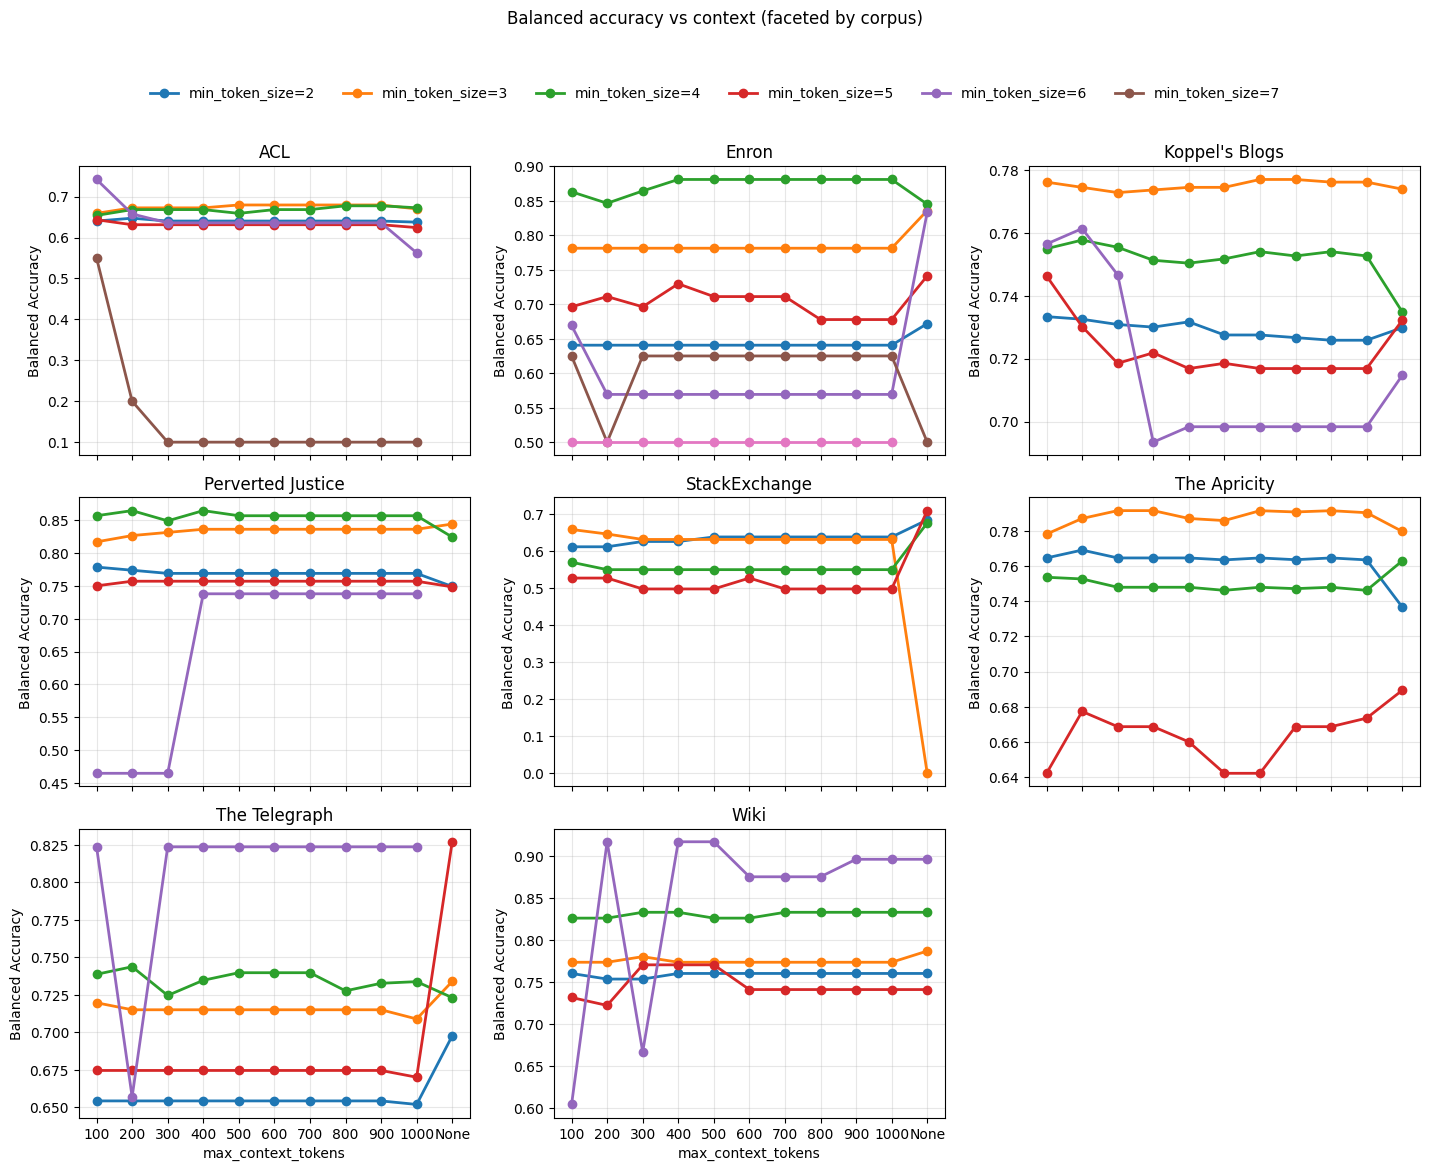

In [7]:
fig, axes = facet_balacc_vs_context_by_corpus(training, ncols=3, agg_fn="mean",
                                              y_col="Balanced Accuracy",
                                              title="Balanced accuracy vs context (faceted by corpus)",
                                              sharey=False)
plt.show()

<positron-console-cell-8>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


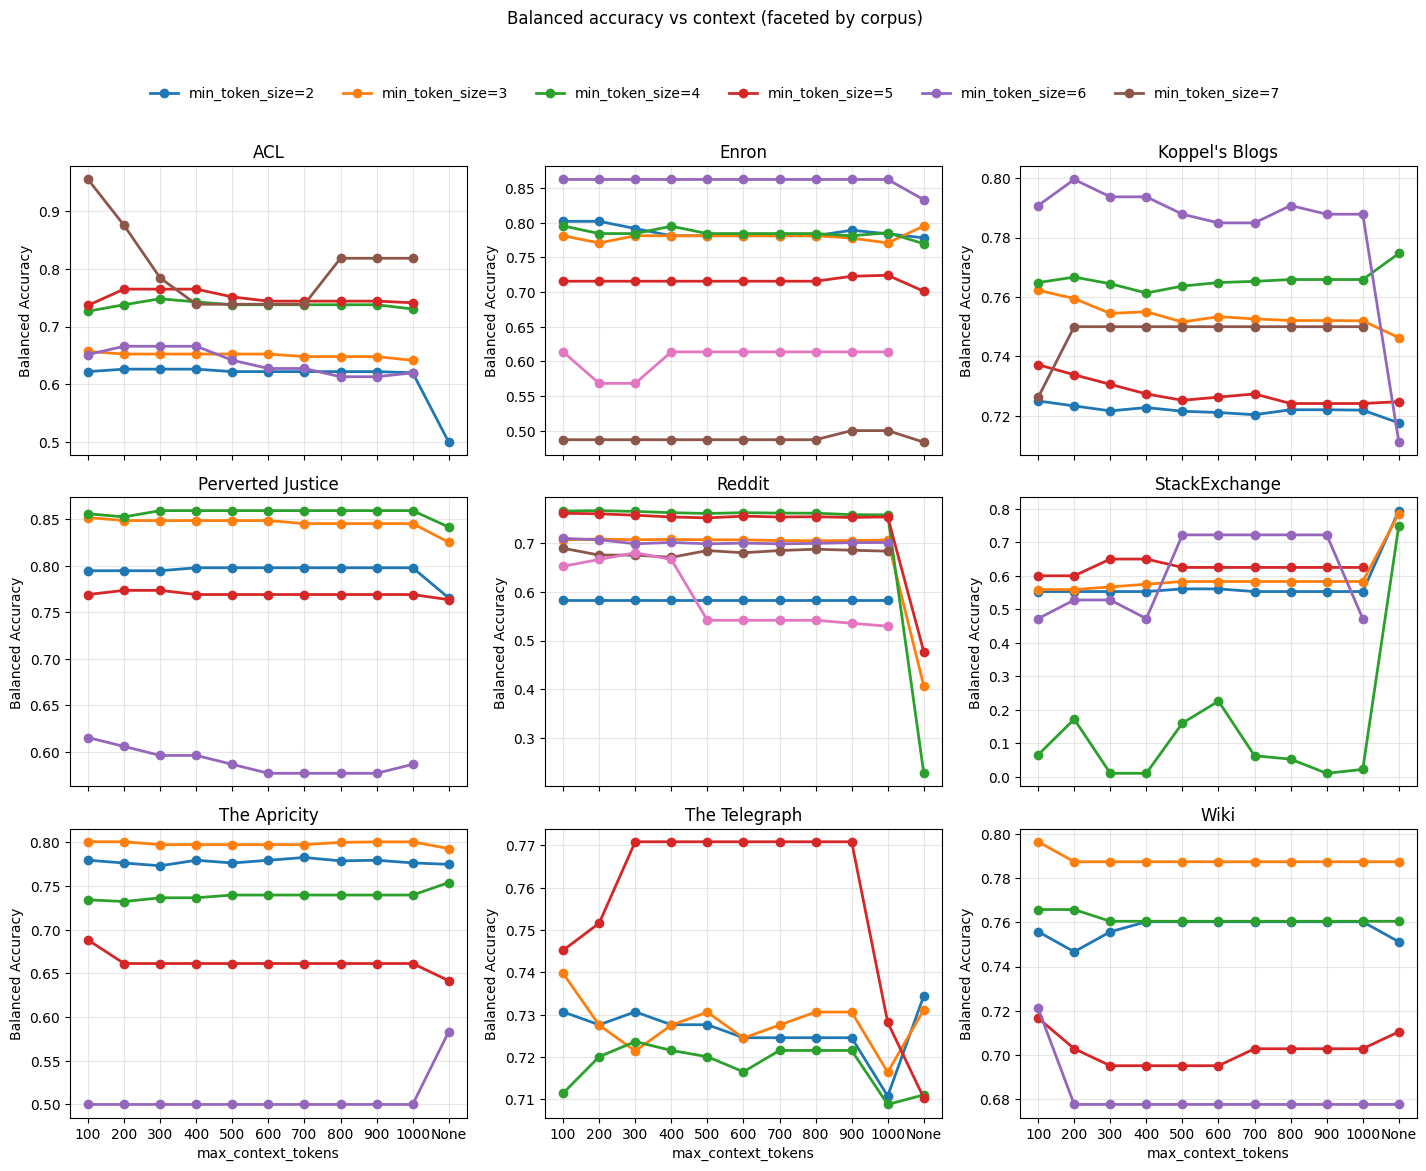

In [8]:
fig, axes = facet_balacc_vs_context_by_corpus(test, ncols=3, agg_fn="mean",
                                              y_col="Balanced Accuracy",
                                              title="Balanced accuracy vs context (faceted by corpus)",
                                              sharey=False)
plt.show()

<positron-console-cell-9>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


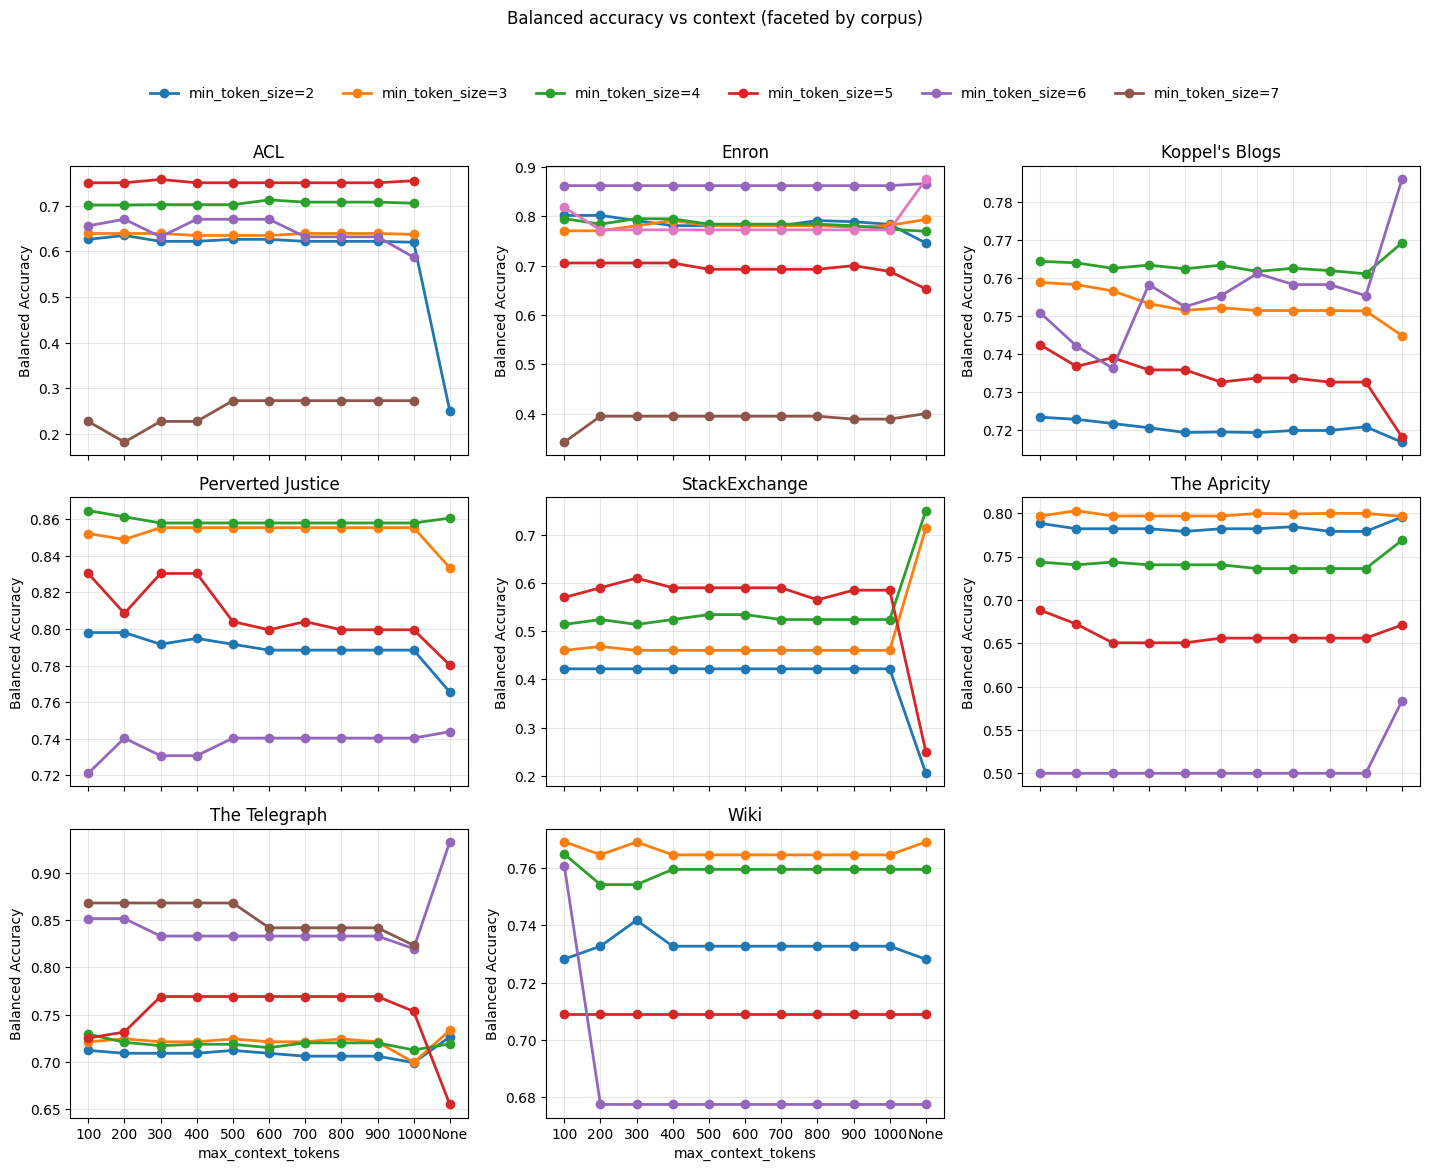

In [9]:
fig, axes = facet_balacc_vs_context_by_corpus(calibrated_df, ncols=3, agg_fn="mean",
                                              y_col="Balanced Accuracy",
                                              title="Balanced accuracy vs context (faceted by corpus)",
                                              sharey=False)
plt.show()